In [359]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import networkx as nx
import random
from skimage.util import view_as_blocks

Number of probes: 100
Patch Size: (64, 64, 1)


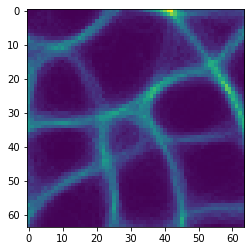

In [369]:
N_PROBES = 100
TRACE = np.load('trace.npy')
G = nx.Graph()
patch = np.copy(TRACE[0:64,0:64,:])
STOCHASTIC_SAMPLING = 0
DOMAIN_SIZE = [63,63]
rng = default_rng()

print('Number of probes:', N_PROBES)
print('Patch Size:', patch.shape)
plt.imshow(patch)

In [370]:
patch.shape

(64, 64, 1)

In [371]:
probe_field = np.zeros((N_PROBES, 4))
probe_field[:, 0] = rng.uniform(low=0.0, high=DOMAIN_SIZE[0], size=probe_field.shape[0])
probe_field[:, 1] = rng.uniform(low=0.0, high=DOMAIN_SIZE[1], size=probe_field.shape[0])
probe_field[:, 2] = rng.uniform(low=0.0, high=2.0*np.pi, size=probe_field.shape[0])
probe_field[:, 3] = 1.0
print(probe_field[0, :])

[ 1.32013048 21.78925933  1.55955426  1.        ]


In [372]:
import math
import random

def world_to_grid_2D(pos_world, size_world, size_grid):
    return (pos_world / size_world) * (size_grid)

def angle_to_dir_2D(angle):
    return np.array([math.cos(float(angle)), math.sin(float(angle))])

def custom_mod(a, b):
    return a - b * math.floor(a / b)

In [373]:
## Main simulation & vis loop
sense_distance = 1.0
sense_angle = 2.5
step_size = 0.1
attenuation = 0.95
weight_multiplier = 0.1
steering_rate = 0.5

# probe_field.from_numpy(probes)

In [375]:
import queue
angle_queue = queue.Queue()
pos_dict = {}
m = 0

for i in range(1000):
    k = m
    for probe in range(probe_field.shape[0]):
        pos1, pos2, angle, weight = probe_field[probe]
        pos = [pos1, pos2]
        dir_fwd = angle_to_dir_2D(angle)
        angle_mut = angle + (random.random() - 0.5) * sense_angle
        dir_mut = angle_to_dir_2D(angle_mut)
        
        t_fwd = world_to_grid_2D(pos + sense_distance * dir_fwd, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
        t_mut = world_to_grid_2D(pos + sense_distance * dir_mut, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
        trace_fwd = patch[t_fwd[0].astype(int)][t_fwd[1].astype(int)][0]
        trace_mut = patch[t_mut[0].astype(int)][t_mut[1].astype(int)][0]
        
        angle_new = 0.0
        if STOCHASTIC_SAMPLING:
            angle_new = (angle) if (random.random() < trace_fwd / (trace_fwd + trace_mut)) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        else:
            angle_new = (angle) if (trace_fwd > trace_mut) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        
        if(G.number_of_nodes() == 0):
            G.add_node(k)
            angle_queue.put(angle_new)
        else:
            if abs(angle_new - angle_queue.queue[0]) > 0.26:
                G.add_node(k)
                G.add_edge(list(G.nodes())[-1], list(G.nodes())[-2])
                
                if(angle_queue.qsize() == 3):
                    angle_queue.get()
                angle_queue.put(angle_new)
                
        pos_dict[k]=(pos1, pos2)
        dir_new = angle_to_dir_2D(angle_new)
        pos_new = pos + step_size * dir_new
 
        pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
        pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

        probe_field[probe][0] = pos_new[0]
        probe_field[probe][1] = pos_new[1]
        probe_field[probe][2] = angle_new
        k = k + 1
    m = m + k

In [376]:
# G.edges

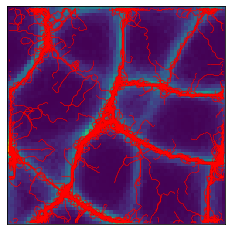

In [378]:
import matplotlib.pyplot as plt
patch_new = np.rot90(patch[:,:,0])
patch_new = np.flipud(patch_new)
plt.imshow(patch_new)
nx.draw_networkx_nodes(G, pos=pos_dict,
#         arrowstyle='->', 
#         arrowsize=20, 
#         width=0.01,
#         with_labels=False, 
        node_size=0.01, 
        node_color='red',)
#         edge_color='blue')
plt.savefig("100_probes_1000_iterations.png", dpi=1000)